[View in Colaboratory](https://colab.research.google.com/github/joheras/CLoDSA/blob/master/notebooks/CLODSA_YOLO.ipynb)

# Augmenting a dataset for object detection in YOLO

In this notebook, we illustrate how CLODSA can be employed to augment a dataset of images devoted to object detection using the [YOLO format](https://pjreddie.com/darknet/yolo/). In particular, we use a subset of the [Pascal VOC dataset](http://host.robots.ox.ac.uk/pascal/VOC/). We will use 20 images from that dataset. Such a subset can be downloaded by executing the following command. 

In [1]:
!wget https://www.dropbox.com/s/7j00clf7tmn1ilm/PascalVOCYOLO.zip?dl=0 -O PascalVOCYOLO.zip
!unzip PascalVOCYOLO.zip

--2019-01-19 13:45:43--  https://www.dropbox.com/s/7j00clf7tmn1ilm/PascalVOCYOLO.zip?dl=0
Resolviendo www.dropbox.com (www.dropbox.com)... 162.125.68.1, 2620:100:6024:1::a27d:4401
Conectando con www.dropbox.com (www.dropbox.com)[162.125.68.1]:443... conectado.
Petición HTTP enviada, esperando respuesta... 301 Moved Permanently
Ubicación: /s/raw/7j00clf7tmn1ilm/PascalVOCYOLO.zip [siguiente]
--2019-01-19 13:45:45--  https://www.dropbox.com/s/raw/7j00clf7tmn1ilm/PascalVOCYOLO.zip
Reutilizando la conexión con www.dropbox.com:443.
Petición HTTP enviada, esperando respuesta... 302 Found
Ubicación: https://uc8a99c4b4215d61b9c7576b01ae.dl.dropboxusercontent.com/cd/0/inline/AZvU6c0Ayb4TkewUrylEYslwoxBnZ-y5cANBYy2GAsF959ktAj1ydsXS5l-Jenf16QKglOJZFIDScCfexMjl8Lv0fy0oExjugEiPg8cOEts0KBa65r6ikoVBGqBm5Kut7ateEpPFVR_UxDxeoL83NfDPrhZms2p4D1ynP07MQdQEqoOzEYttFCYowwbMbXmSTLw/file# [siguiente]
--2019-01-19 13:45:45--  https://uc8a99c4b4215d61b9c7576b01ae.dl.dropboxusercontent.com/cd/0/inline/AZvU6c0Ayb4T

We can check the amount of images in each one of the folders.

In [2]:
print("Number of images in the folder")
!ls -1 PascalVOCYOLO/*.jpg | wc -l

Number of images in the folder
20


## Augmentation techniques

In this notebook, we will use the following augmentation techniques:
- Vertical, horizontal, and vertical-horizontal flips.
- 180º Rotation.
- Average blurring.
- Raise the hue value. 

## Installing the necessary libraries

In case that CLODSA is not installed in your system, the first task consists in installing it using ``pip``.

In [3]:
!pip install clodsa

## Loading the necessary libraries

The first step in the pipeline consists in loading the necessary libraries to apply the data augmentation techniques in CLODSA. We also load some libraries to show the results.

In [4]:
from matplotlib import pyplot as plt
from clodsa.augmentors.augmentorFactory import createAugmentor
from clodsa.transformers.transformerFactory import transformerGenerator
from clodsa.techniques.techniqueFactory import createTechnique
import xml.etree.ElementTree as ET
import cv2
%matplotlib inline

Using TensorFlow backend.


## Creating the augmentor object

As explained in the documentation of CLODSA, we need to specify some parameters for the augmentation process, and use them to create an augmentor object.  

_The kind of problem_. In this case, we are working in a detection problem

In [5]:
PROBLEM = "detection"

_The annotation mode_. We use the YOLO format. 

In [6]:
ANNOTATION_MODE = "yolo"

_The input path_. The input path containing the images. 

In [7]:
INPUT_PATH = "PascalVOCYOLO/"

_The generation mode_. In this case, linear, that is, all the augmentation techniques are applied to all the images of the original dataset. 

In [8]:
GENERATION_MODE = "linear"

_The output mode_. The generated images will be stored in a new folder called augmented_images.  

In [9]:
OUTPUT_MODE = "yolo"
OUTPUT_PATH= "augmented_images_yolo"

Using the above information, we can create our augmentor object. 

In [10]:
augmentor = createAugmentor(PROBLEM,ANNOTATION_MODE,OUTPUT_MODE,GENERATION_MODE,INPUT_PATH,{"outputPath":OUTPUT_PATH})

## Adding the augmentation techniques

Now, we define the techniques that will be applied in our augmentation process and add them to our augmentor object. To illustrate the transformations, we will use the following image of the dataset. 



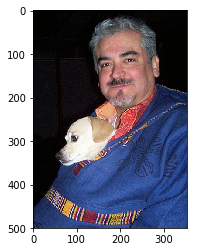

In [11]:
img = cv2.imread("PascalVOCYOLO/000001.jpg")
# changing to the BGR format of OpenCV to RGB format for matplotlib
plt.imshow(img[:,:,::-1])

Just for showing the results of applying data augmentation in an object detection problem, we define a function to read the annotations and another one to show them. This funcionality is not necessary when using CLODSA since it is already implemented in there. 

In [12]:
def boxesFromYOLO(imagePath,labelPath):
    image = cv2.imread(imagePath)
    (hI, wI) = image.shape[:2]
    lines = [line.rstrip('\n') for line in open(labelPath)]
    #if(len(objects)<1):
    #    raise Exception("The xml should contain at least one object")
    boxes = []
    if lines != ['']:
        for line in lines:
            components = line.split(" ")
            category = components[0]
            x  = int(float(components[1])*wI - float(components[3])*wI/2)
            y = int(float(components[2])*hI - float(components[4])*hI/2)
            h = int(float(components[4])*hI)
            w = int(float(components[3])*wI)
            boxes.append((category, (x, y, w, h)))
    return (image,boxes)

In [13]:
categoriesColors = {11: (255,0,0),14:(0,0,255)}

def showBoxes(image,boxes):
    cloneImg = image.copy()
    for (category, (x, y, w, h)) in boxes:
        if int(category) in categoriesColors.keys():
            cv2.rectangle(cloneImg,(x,y),(x+w,y+h),categoriesColors[int(category)],5)
        else:
            cv2.rectangle(cloneImg,(x,y),(x+w,y+h),(0,255,0),5)
    plt.imshow(cloneImg[:,:,::-1])
    

Now, we show the annotation of the image.

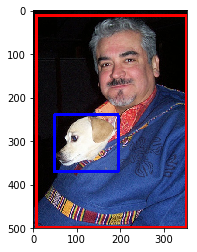

In [14]:
img,boxes = boxesFromYOLO("PascalVOCYOLO/000001.jpg","PascalVOCYOLO/000001.txt")
showBoxes(img,boxes)

First of all, we must define a transformer generator.

In [15]:
transformer = transformerGenerator(PROBLEM)

#### Vertical flip

In [16]:
vFlip = createTechnique("flip",{"flip":0})
augmentor.addTransformer(transformer(vFlip))

Showing the result of applying the transformation.

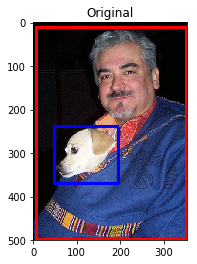

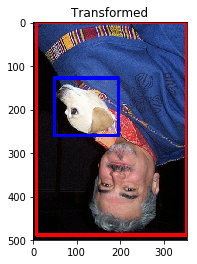

In [17]:
plt.figure()
plt.title("Original")
showBoxes(img,boxes)
vFlipGenerator = transformer(vFlip)
vFlipImg,vFlipBoxes = vFlipGenerator.transform(img,boxes)
plt.figure()
plt.title("Transformed")
showBoxes(vFlipImg,vFlipBoxes)

#### Horizontal flip

In [18]:
hFlip = createTechnique("flip",{"flip":1})
augmentor.addTransformer(transformer(hFlip))

Showing the result of applying the transformation.

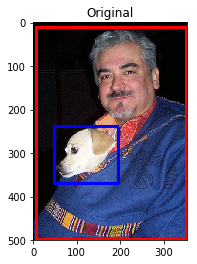

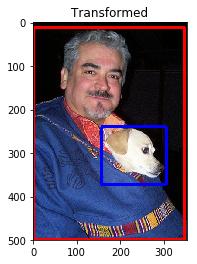

In [19]:
plt.figure()
plt.title("Original")
showBoxes(img,boxes)
hFlipGenerator = transformer(hFlip)
hFlipImg,hFlipBoxes = hFlipGenerator.transform(img,boxes)
plt.figure()
plt.title("Transformed")
showBoxes(hFlipImg,hFlipBoxes)

#### Horizontal and vertical flip

In [20]:
hvFlip = createTechnique("flip",{"flip":-1})
augmentor.addTransformer(transformer(hvFlip))

Showing the result of applying the transformation.

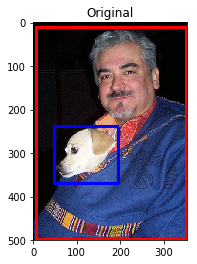

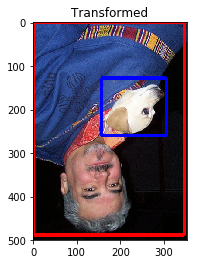

In [21]:
plt.figure()
plt.title("Original")
showBoxes(img,boxes)
hvFlipGenerator = transformer(hvFlip)
hvFlipImg,hvFlipBoxes = hvFlipGenerator.transform(img,boxes)
plt.figure()
plt.title("Transformed")
showBoxes(hvFlipImg,hvFlipBoxes)

#### Rotation:

In [22]:
rotate = createTechnique("rotate", {"angle" : 90})
augmentor.addTransformer(transformer(rotate))

Showing the result of applying the transformation.

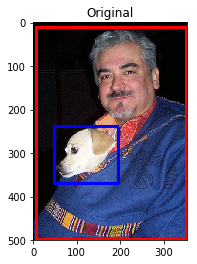

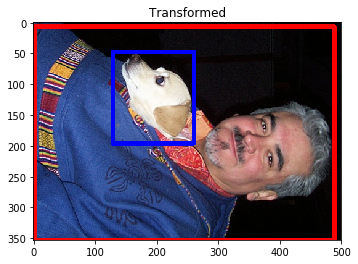

In [23]:
plt.figure()
plt.title("Original")
showBoxes(img,boxes)
rotateGenerator = transformer(rotate)
rotateImg,rotateBoxes = rotateGenerator.transform(img,boxes)
plt.figure()
plt.title("Transformed")
showBoxes(rotateImg,rotateBoxes)

#### Average blurring

In [24]:
avgBlur =  createTechnique("average_blurring", {"kernel" : 5})
augmentor.addTransformer(transformer(avgBlur))

Showing the result of applying the transformation.

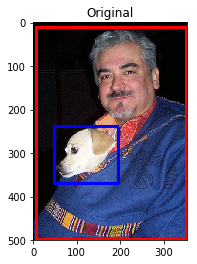

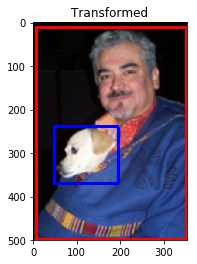

In [25]:
plt.figure()
plt.title("Original")
showBoxes(img,boxes)
avgBlurGenerator = transformer(avgBlur)
avgBlurImg,avgBlurBoxes = avgBlurGenerator.transform(img,boxes)
plt.figure()
plt.title("Transformed")
showBoxes(avgBlurImg,avgBlurBoxes)

#### Raise Hue

In [26]:
hue = createTechnique("raise_hue", {"power" : 0.9})
augmentor.addTransformer(transformer(hue))

Showing the result of applying the transformation.

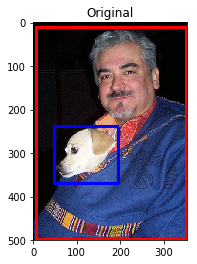

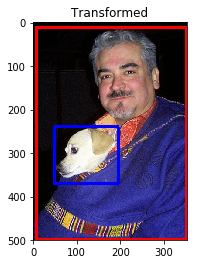

In [27]:
plt.figure()
plt.title("Original")
showBoxes(img,boxes)
hueGenerator = transformer(hue)
hueImg,hueBoxes = hueGenerator.transform(img,boxes)
plt.figure()
plt.title("Transformed")
showBoxes(hueImg,hueBoxes)

#### None
(to keep also the original image)

In [28]:
none = createTechnique("none",{})
augmentor.addTransformer(transformer(none))

## Applying the augmentation process

Finally, we apply the augmentation process (this might take some time depending on the number of images of the original dataset and the number of transformations that will be applied). 

In [29]:
augmentor.applyAugmentation()

Finally, we can check the amount of images in the output folder.

In [30]:
print("Number of images in the folder")
!ls -1 augmented_images_yolo/*.jpg | wc -l
print("Number of annotations in the folder")
!ls -1 augmented_images_yolo/*.txt | wc -l

Number of images in the folder
140
Number of annotations in the folder
140


If you are executing this notebook in Colaboratory, you need to download the generated files. To that aim, you can create a zip folder and download it using the following commands. 

In [ ]:
!zip -r augmented_images_yolo.zip augmented_images_yolo
from google.colab import files
files.download('augmented_images_yolo.zip')